# Part 1: Power Analysis

In [2]:
from statsmodels.stats.power import TTestIndPower

# parameters for power analysis 
# effect: standardized effect size, difference between the two means divided by the standard deviation.
# effect_size has to be positive.

effect = 0.1
alpha = 0.05
power = 0.8

# perform power analysis 
analysis = TTestIndPower()
result = analysis.solve_power(effect, power = power,nobs1= None, ratio = 1.0, alpha = alpha)
print('Sample Size: %.3f' % round(result))

Sample Size: 1571.000


# Part 2: Data Generation Process Through Statistical Simulation
Variables to be simulated: 
1. userid
2. version
3. minutes of plays 
4. user engagement after 1 day (metric_1)
5. user engagement after 7 days (metric_2)

In [3]:
# variable 1: userid
user_id_control = list(range(1,1601))# 1600 control
user_id_treatment = list(range(1601,3350))# 1749 treated

----

In [4]:
#variable 2: version 
import numpy as np
control_status = ['control']*1600
treatment_status = ['treatment']*1749   

----

In [5]:
# variable 3: minutes of plays, which follows a normal distribution with a μ of 30 minutes and σ² of 10 (central limit theorem)

# for control group

μ_1 = 30

σ_squared_1 = 10

np.random.seed(123)

minutes_control = np.random.normal(loc = μ_1, scale = σ_squared_1, size = 1600)

In [6]:
# for treatment group, which increases the user engagement by 
# according to the formula (μ_1 - μ_2)/σ_squared = 0.1, we obtain μ_2 = 31

μ_2 = 31

σ_squared_2 = 10

np.random.seed(123)

minutes_treat = np.random.normal(loc = μ_2, scale = σ_squared_2, size = 1749)

----

In [7]:
# variable 4 user engagement after 1 day (metric_1)
# after day 1, treatment performs better than control --> to simulate novelty effect

Active_status = [True,False]

# control  
day_1_control = np.random.choice(Active_status, 1600, p=[0.3,0.7])

# treatment
day_1_treatment = np.random.choice(Active_status, 1749, p=[0.35,0.65])

----

In [8]:
# variable 5 user engagement after 7 day (metric_2)
# after day 7, control > treatment --> the novelty effect diminishes & performance reversed

Active_status = [True,False]

# control  
day_7_control = np.random.choice(Active_status, 1600, p=[0.35,0.65])

# treatment
day_7_treatment = np.random.choice(Active_status, 1749, p=[0.25,0.75])

----

# construct the control group 

1. user_id_control; 
2. control_status
3. minutes_control
4. day_1_control
5. day_7_control

In [10]:
# control data
import pandas as pd
raw_control = {'user_id':user_id_control,
                 'version':control_status,
               'minutes_play':minutes_control,
               'day_1_active':day_1_control,
               'day_7_active':day_1_control
                }

control_group = pd.DataFrame(data = raw_control)
control_group

,user_id,version,minutes_play,day_1_active,day_7_active
0,1,control,19.143694,False,False
1,2,control,39.973454,False,False
2,3,control,32.829785,False,False
3,4,control,14.937053,False,False
4,5,control,24.213997,True,True
...,...,...,...,...,...
1595,1596,control,27.154466,True,True
1596,1597,control,46.414042,True,True
1597,1598,control,41.523560,False,False
1598,1599,control,23.981909,False,False


1. user_id_treatment
2. treatment_status 
3. minutes_treat
4. day_1_treatment
5. day_7_treatment

In [11]:
# treatment data 
raw_treatment = {'user_id':user_id_treatment,
                 'version':treatment_status,
               'minutes_play':minutes_treat,
               'day_1_active':day_1_treatment,
               'day_7_active':day_7_treatment
                }

treatment_group = pd.DataFrame(data = raw_treatment)
treatment_group

,user_id,version,minutes_play,day_1_active,day_7_active
0,1601,treatment,25.515817,False,False
1,1602,treatment,41.653829,False,False
2,1603,treatment,25.760776,False,False
3,1604,treatment,36.459880,True,False
4,1605,treatment,25.341199,True,False
...,...,...,...,...,...
1744,3345,treatment,24.098838,True,False
1745,3346,treatment,29.683718,True,False
1746,3347,treatment,34.013900,True,False
1747,3348,treatment,44.909702,False,False


In [12]:
# combine these two datasets
two_datasets = control_group.append(treatment_group)

# randomize the orders using df.sample(frac=1)
# The frac keyword argument: specifies the fraction of rows to return in the random sample
# so frac=1 means return all rows (in random order).
final_data = two_datasets.sample(frac=1)

In [13]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3349 entries, 1558 to 345
Data columns (total 5 columns):
user_id         3349 non-null int64
version         3349 non-null object
minutes_play    3349 non-null float64
day_1_active    3349 non-null bool
day_7_active    3349 non-null bool
dtypes: bool(2), float64(1), int64(1), object(1)
memory usage: 111.2+ KB


In [29]:
final_data.head()

,user_id,version,minutes_play,day_1_active,day_7_active,minutes_play_integers
1558,3159,treatment,26.156152,False,True,26.0
1223,1224,control,24.313143,False,False,24.0
392,393,control,29.013153,True,True,29.0
808,809,control,27.797075,True,True,28.0
485,2086,treatment,32.152395,False,False,32.0


# Part 3: After-Test Data Analysis

### 3.1 Count the Number of Users in Each Version 

In [14]:
# calculate the number of users in each version
final_data.groupby('version')['user_id'].count()

version
control      1600
treatment    1749
Name: user_id, dtype: int64

# the assignment process looks suspicious as more people assigned to the treatment than the control. 

### 3.2 Formally Test for Sample Ratio Mismatch
- Chi-Square test

In [30]:
from scipy.stats import chisquare 
chisquare([1600,1749],f_exp = [1675,1675])

Power_divergenceResult(statistic=6.627462686567164, pvalue=0.010041820594939122)

Typically, we set the alpha level at 0.001 to test Sample Ratio Mismatch. Since the p value is 0.01, we have to reject the null hypothesis and conclude no evidence of SRM.
In other words, the treatment assignment works as expected.

In [31]:
final_data.head()

,user_id,version,minutes_play,day_1_active,day_7_active,minutes_play_integers
1558,3159,treatment,26.156152,False,True,26.0
1223,1224,control,24.313143,False,False,24.0
392,393,control,29.013153,True,True,29.0
808,809,control,27.797075,True,True,28.0
485,2086,treatment,32.152395,False,False,32.0


### 3.3 Plot the Distribution of Video Played for Each Group 

Text(0, 0.5, 'User Count')

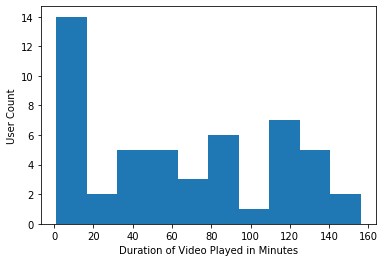

In [39]:
%matplotlib inline

final_data['minutes_play_integers'] = round(final_data['minutes_play'])
plot_df = final_data.groupby('minutes_play_integers')['user_id'].count()

# Plot the distribution of players that played 0 to 50 minutes
ax = plot_df.head(n=50).plot(x="minutes_play_integers", y="user_id", kind="hist")
ax.set_xlabel("Duration of Video Played in Minutes")
ax.set_ylabel("User Count")

# Metric 1: 1-day retention by AB-Group

In [35]:
# 1-day retention
final_data['day_1_active'].mean()

0.3248730964467005

In [36]:
# 1-day retention by group
final_data.groupby('version')['day_1_active'].mean()

version
control      0.296875
treatment    0.350486
Name: day_1_active, dtype: float64

# Some interesting questions:
1. Treatment has a higher retention rate (0.35) than the control (0.29). Is the difference significant?
2. To what extent can we trust the result?
3. What is the variability of the difference? 
4. In other words, how many times do we obtain more extreme values, if we repeat the process for 100 times?
--> Solution: Bootstrap (resampling, replication) and check for the variability 

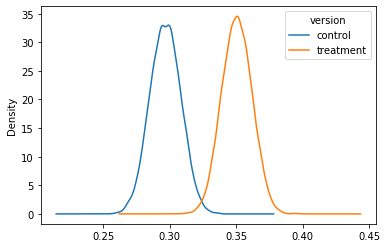

In [20]:
# solution: bootstrap
boot_means = []

# run the simulation for 10k times 
for i in range(10000):
    #frac=1 means randomize the order of all rows 
    boot_sample = final_data.sample(frac=1,replace=True).groupby('version')['day_1_active'].mean()
    boot_means.append(boot_sample)

# a Pandas DataFrame
boot_means = pd.DataFrame(boot_means)

# kernel density estimate
boot_means.plot(kind = 'kde')

In [22]:
# create a new column, diff, which is the difference between the two variants, scaled by the control group
boot_means['diff'] = (boot_means['treatment'] - boot_means['control'])/boot_means['control']*100

In [23]:
boot_means['diff']

day_1_active    12.603674
day_1_active    20.623621
day_1_active    17.682652
day_1_active    20.093840
day_1_active    15.809040
                  ...    
day_1_active    13.919948
day_1_active    17.328947
day_1_active    13.024745
day_1_active    22.401725
day_1_active    19.605505
Name: diff, Length: 10000, dtype: float64

Text(0.5, 0, '% diff in means')

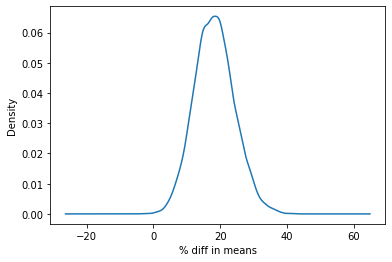

In [24]:
# plot the bootstrap sample difference 
ax = boot_means['diff'].plot(kind = 'kde')
ax.set_xlabel("% diff in means")

In [25]:
boot_means[boot_means['diff'] > 0]

version,control,treatment,diff
day_1_active,0.317058,0.357019,12.603674
day_1_active,0.291641,0.351788,20.623621
day_1_active,0.287832,0.338728,17.682652
day_1_active,0.268777,0.322785,20.093840
day_1_active,0.307161,0.355720,15.809040
...,...,...,...
day_1_active,0.299690,0.341407,13.919948
day_1_active,0.294154,0.345128,17.328947
day_1_active,0.314162,0.355081,13.024745
day_1_active,0.292459,0.357974,22.401725


In [26]:
# p value 
p = (boot_means['diff'] >0).sum()/len(boot_means)
p

0.9996

# Conclusion 1: treatment has a better performance than the control on 1-day user retention 99.96% of the time.

# Metric 7: 7-day retention by AB-Group

In [37]:
boot_7d = []

for i in range(10000):
    #set frac=1 --> sample all rows
    boot_mean = final_data.sample(frac=1,replace=True).groupby('version')['day_7_active'].mean() 
    boot_7d.append(boot_mean)
    
boot_7d = pd.DataFrame(boot_7d)

boot_7d['diff'] = (boot_7d['treatment'] - boot_7d['control'])/boot_7d['control'] *100

Text(0.5, 0, '% diff in means')

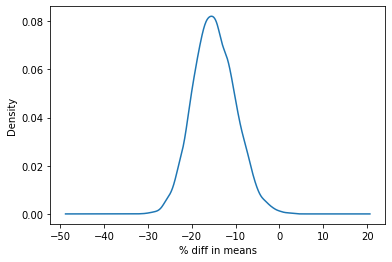

In [40]:
# Ploting the bootstrap % difference
ax = boot_7d['diff'].plot(kind = 'kde')
ax.set_xlabel("% diff in means")

In [41]:
# Calculating the probability that 7-day retention is greater when the gate is at level 30
p = (boot_7d['diff']>0).sum()/len(boot_7d)

1-p

0.9983

# Conclusion 2: control has a better performance than the treatment on 7-day user retention 99.89% of the time.

## After double-checking with the true parameters, these two estimates are unbiased estimates.